# Temat Projektu: Klasyfikacja tekstu, detekcja fake-newsów
### Autor: Jerzy Muszyński

## Część 2: Model Językowy typu Encoder (DistilBERT)

**Cel Notatnika:**
W poprzedniej części (Baseline) wykorzystaliśmy proste metody statystyczne (TF-IDF), które traktują tekst jako "worek słów" (Bag of Words), ignorując ich kolejność i kontekst.
W tej części przechodzimy do nowoczesnego przetwarzania języka naturalnego (NLP) opartego na architekturze **Transformer**.

**Metodologia:**
Skupimy się na architekturze typu **Encoder-Only**. Naszym modelem będzie **DistilBERT** – lżejsza i szybsza wersja modelu BERT (Bidirectional Encoder Representations from Transformers).

In [ ]:
!nvidia-smi

Sat Jan 31 16:01:01 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## 1. Konfiguracja Środowiska i Funkcje Pomocnicze

W przeciwieństwie do Regresji Logistycznej, sieci neuronowe wymagają znacznie większych zasobów obliczeniowych (GPU).
* **Zarządzanie pamięcią:** Definiujemy funkcję `cleanup()`, która będzie regularnie czyścić pamięć VRAM karty graficznej, aby uniknąć błędów *Out Of Memory* (OOM).
* **Biblioteki:** Korzystamy z ekosystemu *Hugging Face Transformers*, który stał się standardem przemysłowym w pracy z modelami LLM.

In [ ]:
!pip -q install datasets scikit-learn umap-learn matplotlib torchmetrics evaluate peft bitsandbytes trl accelerate


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import gc
import pandas as pd
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from datasets import load_dataset
import umap
import random
from torch.nn import functional as F


print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.9.0+cu126


In [ ]:
is_cuda = torch.cuda.is_available()
print(f"GPU Availability: {is_cuda}")

if is_cuda:
  print(f"GPU type: {torch.cuda.get_device_name(0)}")
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

GPU Availability: True
GPU type: NVIDIA A100-SXM4-40GB


In [ ]:
def cleanup():
    if 'model' in globals():
        del globals()['model']
    if 'tokenizer' in globals():
        del globals()['tokenizer']
    if 'trainer' in globals():
        del globals()['trainer']

    gc.collect()
    torch.cuda.empty_cache()
    print("Memory cleaned.")

In [ ]:
def calculate_metrics_core(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    acc = accuracy_score(y_true, y_pred)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
def show_report_and_cm(y_true, y_pred, label_names = ["REAL", "FAKE"], title_prefix=""):
    print(f"\n=== Classification report ({title_prefix}) ===")
    print(classification_report(
        y_true, y_pred,
        target_names=label_names,
        digits=3
    ))

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

    disp.plot(colorbar=False, cmap="Blues")
    plt.tight_layout()
    plt.title(f"Confusion matrix – {title_prefix}")
    plt.show()

In [ ]:
def plot_training_dynamics(trainer):
    history = trainer.state.log_history
    train_steps = [x['step'] for x in history if 'loss' in x]
    train_loss = [x['loss'] for x in history if 'loss' in x]

    eval_steps = [x['step'] for x in history if 'eval_loss' in x]
    eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

    plt.figure(figsize=(10, 5))
    plt.plot(train_steps, train_loss, label='Training Loss', color='tab:blue', alpha=0.7)
    if eval_loss:
        plt.plot(eval_steps, eval_loss, label='Validation Loss', color='tab:orange', linewidth=2)


    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Dynamics')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

In [ ]:
def add_input_text(data_point):
  title = data_point.get("title", "")
  text = data_point.get("text", "")
  data_point["input_text"] = (title.strip() + "\n " + text.strip()).strip()
  return data_point

## 2. Przygotowanie Danych: Tokenizacja

Modele Transformer nie rozumieją surowego tekstu ani wektorów TF-IDF. Wymagają one specyficznego formatu wejściowego.

**Proces Tokenizacji:**
Używamy dedykowanego tokenizera dla modelu `distilbert-base-uncased`.
1.  **Subword Tokenization:** Słowa są dzielone na podjednostki (np. "tokenization" -> "token", "##iza", "##tion"). Pozwala to ograniczyć rozmiar słownika i radzić sobie z nieznanymi słowami.
2.  **Input IDs:** Każdy token jest zamieniany na unikalny numer identyfikacyjny.
3.  **Attention Mask:** Wskazuje modelowi, które tokeny są prawdziwym tekstem, a które są tylko "wypełniaczem" (padding) służącym do wyrównania długości zdań w batchu.
4.  **Truncation/Padding:** Wszystkie wejścia sprowadzamy do stałej długości (tutaj: 512 tokenów), przycinając zbyt długie teksty lub dopełniając zbyt krótkie.

In [ ]:
def prepare_encoder_data(dataset, model_name, max_length=512):
    print(f"Tokenizing data for {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize_batch(batch):
      return tokenizer(batch["input_text"], truncation=True, max_length=512)

    tokenized_ds = dataset.map(tokenize_batch, batched=True)

    return tokenized_ds, tokenizer

In [ ]:
ds = load_dataset("ErfanMoosaviMonazzah/fake-news-detection-dataset-English")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
example = ds["train"][random.randint(0, len(ds["train"]))]
print(example)
print(f"Title: {example['title']}")
print(f"Content: {example['text']}")
print(f"Label: {"Real" if example['label'] == 1 else "Fake"}")

{'Unnamed: 0': 13154, 'title': "'Kiss of death' to two-state solution if Jerusalem declared Israel capital: PLO envoy", 'text': 'A formal U.S. recognition of Jerusalem as the capital of Israel would be the  kiss of death  to the two-state solution to the Israeli-Palestinian conflict, the Palestine Liberation Organization s chief representative in Washington said on Monday.  Should such a step be taken, it would have catastrophic consequences,  Husam Zomlot told Reuters in an interview.   That would be actually the kiss of death to the two-state solution because Jerusalem is at the very heart of the two-state solution,  Zomlot said. A senior administration official told Reuters last week that U.S. President Donald Trump would likely make the announcement on Wednesday, although his adviser and son-in-law, Jared Kushner, said the president had not yet made a final decision. Such a declaration would break with decades of U.S. policy and could fuel violence in the Middle East. Past U.S. pre

In [ ]:
ds = ds.map(add_input_text)
ds["train"][0]["input_text"]

"Ex-CIA head says Trump remarks on Russia interference 'disgraceful'\n Former CIA director John Brennan on Friday criticized as “disgraceful” President Donald Trump’s efforts to play down U.S. intelligence agencies’ assessment that Russia meddled in the 2016 U.S. election. Trump’s administration has been dogged by investigations into allegations of Russian interference in last year’s U.S. presidential election and possible ties with his campaign team. Speaking one day before his first meeting with Russian President Vladimir Putin in Hamburg earlier this month, Trump said he suspected Russian interference in the election but that no one knows for sure. “These types of comments are just disgraceful ... and the person who said them should be ashamed of himself,” said Brennan, CIA chief under former President Barack Obama, at the Aspen Security Forum. Special Counsel Robert Mueller and several U.S. congressional committees are investigating whether Russia interfered in the election and col

## Podejście 2.
Klasyfikator probabilistyczny oparty o wybrany model klasy tylko-koder dostrojony na zbiorze treningowym.  

In [ ]:
model_name = "distilbert-base-uncased"

In [ ]:
tokenized_ds, tokenizer = prepare_encoder_data(ds, model_name)

Tokenizing data for distilbert-base-uncased...


Map:   0%|          | 0/8267 [00:00<?, ? examples/s]

In [ ]:
token_ids = tokenizer.encode(example["text"])
print(f"Token ids: {token_ids}")
tokens = tokenizer.convert_ids_to_tokens(token_ids)
print(f"Tokens: {tokens}")

Token indices sequence length is longer than the specified maximum sequence length for this model (596 > 512). Running this sequence through the model will result in indexing errors


Token ids: [101, 1037, 5337, 1057, 1012, 1055, 1012, 5038, 1997, 6744, 2004, 1996, 3007, 1997, 3956, 2052, 2022, 1996, 3610, 1997, 2331, 2000, 1996, 2048, 1011, 2110, 5576, 2000, 1996, 5611, 1011, 9302, 4736, 1010, 1996, 8976, 7931, 3029, 1055, 2708, 4387, 1999, 2899, 2056, 2006, 6928, 1012, 2323, 2107, 1037, 3357, 2022, 2579, 1010, 2009, 2052, 2031, 23546, 8465, 1010, 15876, 21559, 1062, 5358, 10994, 2409, 26665, 1999, 2019, 4357, 1012, 2008, 2052, 2022, 2941, 1996, 3610, 1997, 2331, 2000, 1996, 2048, 1011, 2110, 5576, 2138, 6744, 2003, 2012, 1996, 2200, 2540, 1997, 1996, 2048, 1011, 2110, 5576, 1010, 1062, 5358, 10994, 2056, 1012, 1037, 3026, 3447, 2880, 2409, 26665, 2197, 2733, 2008, 1057, 1012, 1055, 1012, 2343, 6221, 8398, 2052, 3497, 2191, 1996, 8874, 2006, 9317, 1010, 2348, 2010, 11747, 1998, 2365, 1011, 1999, 1011, 2375, 1010, 8334, 13970, 4095, 3678, 1010, 2056, 1996, 2343, 2018, 2025, 2664, 2081, 1037, 2345, 3247, 1012, 2107, 1037, 8170, 2052, 3338, 2007, 5109, 1997, 1057, 10

In [ ]:
print(tokenized_ds)

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'subject', 'date', 'label', 'input_text', 'input_ids', 'attention_mask'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'subject', 'date', 'label', 'input_text', 'input_ids', 'attention_mask'],
        num_rows: 6000
    })
    test: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'subject', 'date', 'label', 'input_text', 'input_ids', 'attention_mask'],
        num_rows: 8267
    })
})


In [ ]:
for i in range(3):
  print(f"\nSample entry nr: {i+1}.")
  index = random.randint(0, len(tokenized_ds["train"]))
  example = tokenized_ds["train"][index]
  print("True" if example["label"] == 1 else "Fake")
  print(example["input_text"])
  print(example["input_ids"])
  print(tokenizer.decode(example["input_ids"]))



Sample entry nr: 1.
True
North Korea says U.S. threats make war unavoidable, China urges calm
 Two U.S. B-1B heavy bombers joined large-scale combat drills over South Korea on Thursday amid warnings from North Korea that the exercises and U.S. threats have made the outbreak of war  an established fact.  The annual U.S.-South Korean  Vigilant Ace  exercises feature 230 aircraft, including some of the most advanced U.S. stealth warplanes, and come a week after North Korea tested its most powerful intercontinental ballistic missile (ICBM) to date, which it says can reach all of the United States. North Korea s foreign ministry blamed the drills and  confrontational warmongering  by U.S. officials for making war inevitable.  The remaining question now is: when will the war break out?  it said in a statement.  We do not wish for a war but shall not hide from it.  China, North Korea s neighbor and lone major ally, again urged calm and said war was not the answer, while Russian Foreign Minis

In [ ]:
def compute_metrics_for_trainer(eval_pred):
    logits, labels = eval_pred

    predictions = np.argmax(logits, axis=-1)

    return calculate_metrics_core(labels, predictions)

## 3. Trening Modelu (Fine-Tuning)

W tym etapie przeprowadzamy właściwe douczanie modelu. Wykorzystujemy klasę `Trainer`, która automatyzuje pętlę treningową.

**Kluczowe elementy konfiguracji:**
* **Model:** `DistilBERT` z dodaną na szczycie warstwą klasyfikacyjną (tzw. *Classification Head*), która redukuje wektor wyjściowy do 2 klas (Real/Fake).
* **Learning Rate (2e-5):** Bardzo niska wartość współczynnika uczenia. Ponieważ model jest już "mądry" (pre-trained), nie chcemy drastycznie zmieniać jego wag, a jedynie delikatnie je skorygować pod nasze dane.
* **Evaluation Strategy:** Model jest ewaluowany na zbiorze walidacyjnym w trakcie treningu (co 250 kroków), abyśmy mogli monitorować postępy i przerwać trening, jeśli zacznie się przeuczać (Early Stopping).
* **Load Best Model:** Na koniec treningu automatycznie przywracamy wagi, które dały najlepszy wynik (najwyższą dokładność lub najniższą stratę).

In [ ]:
def run_encoder_training(model_name, device, compute_metrics, tokenized_ds, tokenizer, output_dir="./encoder_output"):
    cleanup()

    print(f"Initializing {model_name}...")
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model.to(device)

    args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=3,
        eval_steps=250,
        load_best_model_at_end=True,
        eval_strategy="steps",
        logging_steps=50,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    print("Starting training...")
    trainer.train()
    print("Training finished.")

    return trainer

In [ ]:
trainer = run_encoder_training(model_name, device, compute_metrics_for_trainer, tokenized_ds, tokenizer)

Memory cleaned.
Initializing distilbert-base-uncased...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-655619354.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
250,0.017500,0.023883,0.994500,0.999653,0.989007,0.994302
500,0.009500,0.009585,0.997500,0.996230,0.998626,0.997427
750,0.013500,0.005310,0.998333,0.998968,0.997595,0.998281
1000,0.004600,0.007077,0.998333,1.000000,0.996565,0.998279
1250,0.005000,0.004311,0.999333,0.998970,0.999656,0.999313
1500,0.002500,0.007639,0.998667,0.997600,0.999656,0.998627
1750,0.006500,0.006048,0.998833,0.998626,0.998969,0.998798
2000,0.000100,0.006281,0.999000,0.998627,0.999313,0.998970
2250,0.000100,0.005256,0.998667,0.999312,0.997939,0.998625
2500,0.000000,0.004303,0.999500,0.999313,0.999656,0.999485


Training finished.


In [ ]:
def extract_encoder_embeddings_stable(model, tokenizer, dataset, n_samples=1000, batch_size=32):
    n_samples = min(n_samples, len(dataset))
    subset = dataset.shuffle(seed=42).select(range(n_samples))

    texts = subset["input_text"]
    labels = subset["label"]

    model.eval()
    embeddings = []

    print(f"Extracting embeddings for {n_samples} samples...")

    for i in tqdm(range(0, n_samples, batch_size)):
        batch_texts = texts[i : i + batch_size]

        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(model.device)

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        cls_emb = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
        embeddings.append(cls_emb)

    X = np.concatenate(embeddings, axis=0)
    y = np.array(labels)

    return X, y

def visualize_encoder_embeddings(trainer, dataset, title_prefix, n_samples=1000):

    X, y = extract_encoder_embeddings_stable(
        trainer.model,
        trainer.tokenizer,
        dataset,
        n_samples=n_samples
    )

    reducer = umap.UMAP(n_components=2, random_state=42)
    X_2d = reducer.fit_transform(X)

    plt.figure(figsize=(7, 5))
    LABEL_NAMES = {0: "Fake", 1: "Real"}

    for lab in [0, 1]:
        idx = (y == lab)
        plt.scatter(
            X_2d[idx, 0],
            X_2d[idx, 1],
            s=10,
            alpha=0.7,
            label=LABEL_NAMES[lab]
        )

    plt.legend()
    plt.title(f"UMAP visualization (DistilBERT) - {title_prefix}")
    plt.show()

## 4. Ewaluacja i Analiza Dynamiki Treningu

Po zakończeniu treningu musimy zweryfikować, czy model faktycznie się czegoś nauczył, czy tylko zapamiętał dane.

**Analizowane aspekty:**
1.  **Krzywa Uczenia (Loss Curve):**
    * Wykres przedstawia spadek funkcji straty (Loss) w czasie.
    * Oczekujemy, że zarówno linia treningowa (niebieska), jak i walidacyjna (pomarańczowa) będą spadać.
    * Jeśli linia walidacyjna zacznie rosnąć, podczas gdy treningowa spada, świadczy to o **przeuczeniu (Overfitting)**.
2.  **Metryki Klasyfikacji:** Ponownie obliczamy Accuracy, Precision, Recall i F1, aby porównać wyniki z modelem bazowym (TF-IDF).
3.  **Macierz Pomyłek:** Sprawdzamy, czy model lepiej radzi sobie z rozróżnianiem klas niż Regresja Logistyczna.

In [ ]:
def evaluate_encoder_pipeline(trainer, device, tokenized_ds):
    print("\n--- FULL EVALUATION ---")

    plot_training_dynamics(trainer)

    for split_name in ["train", "test", "validation"]:
        print(f"\nPredicting on {split_name} set...")
        preds_output = trainer.predict(tokenized_ds[split_name])
        y_pred = np.argmax(preds_output.predictions, axis=-1)
        y_true = preds_output.label_ids

        show_report_and_cm(y_true, y_pred, title_prefix=f"{split_name.capitalize()} Set")

        visualize_encoder_embeddings(trainer, tokenized_ds[split_name], f"{split_name} dataset", n_samples=1000)


## 5. Wizualizacja Reprezentacji Wewnętrznej (Embeddings)

To najbardziej interesująca część analizy. W TF-IDF patrzyliśmy na występowanie słów. Tutaj patrzymy na to, jak sieć neuronowa "rozumie" treść.

**Token [CLS]:**
W architekturze BERT pierwszy token każdej sekwencji to specjalny token `[CLS]` (Classification). Model jest uczony tak, aby wektor reprezentujący ten jeden token skupiał w sobie "esencję" całego zdania. To właśnie ten wektor służy do podjęcia decyzji Real/Fake.


--- FULL EVALUATION ---


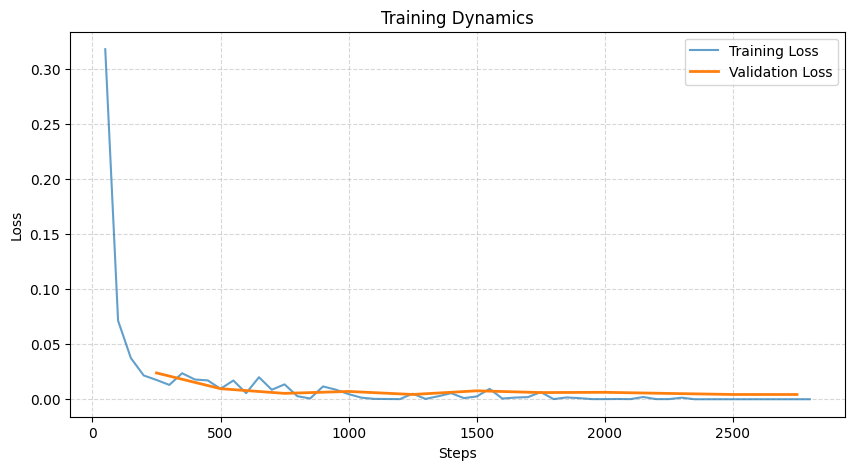


Predicting on train set...



=== Classification report (Train Set) ===
              precision    recall  f1-score   support

        REAL      1.000     1.000     1.000     15478
        FAKE      1.000     1.000     1.000     14522

    accuracy                          1.000     30000
   macro avg      1.000     1.000     1.000     30000
weighted avg      1.000     1.000     1.000     30000



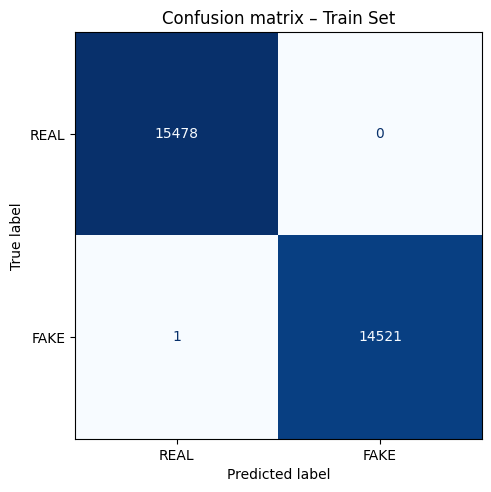

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Extracting embeddings for 1000 samples...


100%|██████████| 32/32 [00:03<00:00,  8.92it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


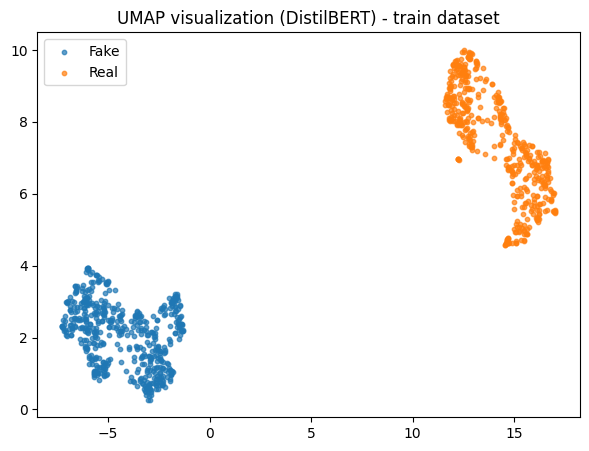


Predicting on test set...



=== Classification report (Test Set) ===
              precision    recall  f1-score   support

        REAL      1.000     0.999     0.999      4284
        FAKE      0.999     1.000     0.999      3983

    accuracy                          0.999      8267
   macro avg      0.999     0.999     0.999      8267
weighted avg      0.999     0.999     0.999      8267



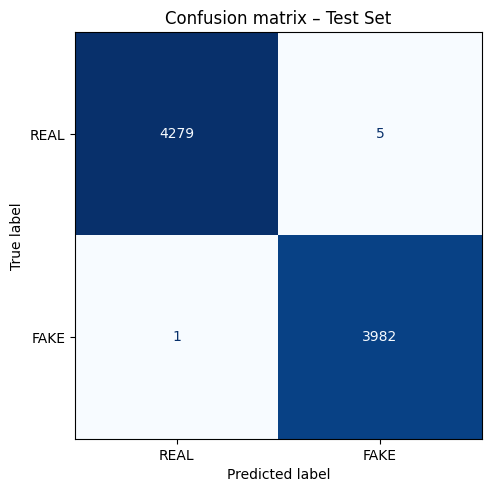

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Extracting embeddings for 1000 samples...


100%|██████████| 32/32 [00:03<00:00,  8.82it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


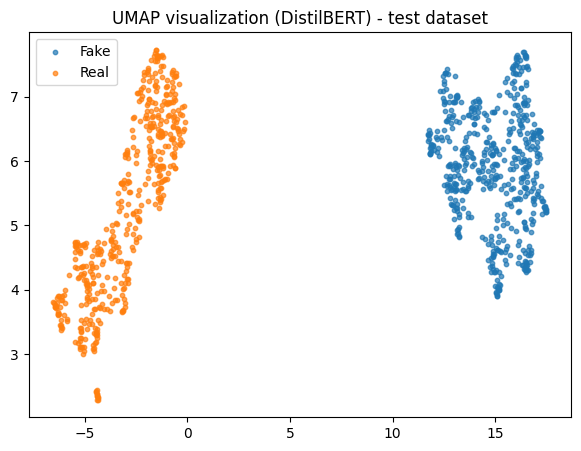


Predicting on validation set...



=== Classification report (Validation Set) ===
              precision    recall  f1-score   support

        REAL      1.000     0.999     1.000      3089
        FAKE      0.999     1.000     0.999      2911

    accuracy                          1.000      6000
   macro avg      0.999     1.000     0.999      6000
weighted avg      1.000     1.000     1.000      6000



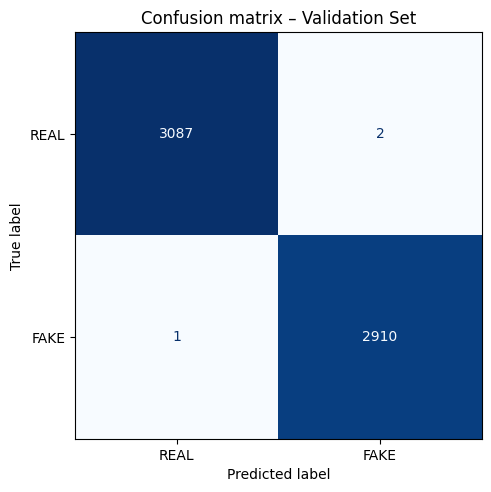

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Extracting embeddings for 1000 samples...


100%|██████████| 32/32 [00:03<00:00,  8.82it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


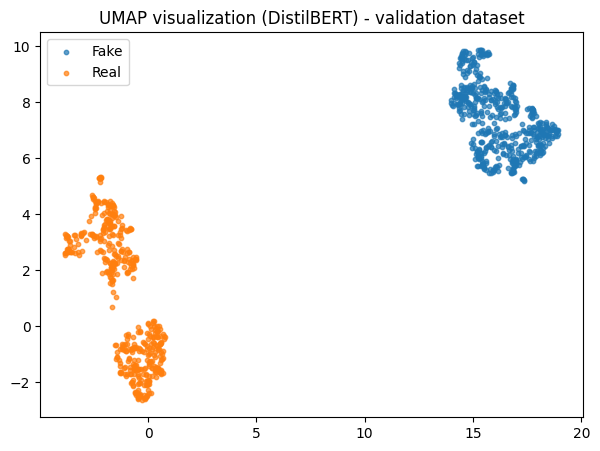

In [ ]:
evaluate_encoder_pipeline(trainer, device, tokenized_ds)

In [ ]:
predictions_test = trainer.predict(tokenized_ds["test"])

In [ ]:
for i in range(3):
  index = random.randint(0, len(tokenized_ds["test"]))
  example = tokenized_ds["test"][index]
  pp = F.softmax(torch.tensor(predictions_test.predictions[index]), dim=0)
  print(f"\nSample entry nr: {i+1}.")
  print(f"Text: {example["input_text"]}")
  print(f"Probability distribution: {pp}")
  print(f"Prediction: {"Real" if torch.argmax(pp) == 1 else "Fake"}")


Sample entry nr: 1.
Text: Magnitude 5.4 quake rumbles southern Mexico, no reports of damage
 A 5.4 magnitude quake struck southern Mexico on Friday, according to the U.S. Geological Survey, but there were no immediate reports of damage.  It was not immediately clear if the tremor was an aftershock from a powerful series of quakes last month that destroyed buildings in Mexico City and killed nearly 500 people. The epicenter of Friday s tremor was just off the coast of Oaxaca state, in Mexico s southwest, and it struck at a depth of 59.5 kilometers (37 miles), according to the USGS. An 8.1 magnitude earthquake struck Oaxaca on Sept. 7 near the town of Juchitan, flattening thousands of buildings in the humid market town.  Fausto Lugo, Mexico City s emergency services chief, said on local television that Friday s earthquake was felt lightly in the capital, but there were no reports of damages.
Probability distribution: tensor([4.0428e-05, 9.9996e-01])
Prediction: Real

Sample entry nr: 2.

# Podsumowanie Części 2

W tym notatniku zbadaliśmy potencjał modeli typu **Encoder** w detekcji fake newsów.

**Wnioski:**
1.  Zastosowanie DistilBERTa zazwyczaj przynosi znaczną poprawę wyników względem TF-IDF, dzięki rozumieniu kontekstu i szyku zdań.
2.  Model ten jest **deterministyczny** w swojej predykcji (dla tego samego wejścia zawsze zwróci ten sam wynik klasyfikacji).
3.  Jest to obecnie standard przemysłowy ("workhorse") w zadaniach klasyfikacji tekstu, oferujący doskonały balans między skutecznością a szybkością działania.

W ostatniej części projektu (**Część 3**) sprawdzimy najnowszy trend w AI: wykorzystanie wielkich generatywnych modeli językowych (**LLM / Decoder-Only**), takich jak Qwen czy Llama, i porównamy, czy "inteligencja ogólna" tych modeli przekłada się na lepszą detekcję dezinformacji.